In [1]:
import librosa
import soundfile
import os
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.models import Model
from keras.layers import (
    Conv1D,
    Activation,
    Dropout,
    MaxPooling1D,
    Flatten,
    Dense,
    Input,
)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
# Function to recursively get all audio files from a directory
def get_audio_files(base_path):
    audio_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files


# Base path for RAVDESS dataset
base_path_RAVDESS = "../data/raw/audio_speech_actors_01-24"

# Get all audio files from RAVDESS and TESS datasets
audio_files_ravdess = get_audio_files(base_path_RAVDESS)
# Save audio files paths
if not os.path.exists("../data/processed/audio_files_ravdess.txt"):
    with open("../data/processed/audio_files_ravdess.txt", "w") as f:
        for item in audio_files_ravdess:
            f.write("%s\n" % item)
    print("../data/processed/audio_files_ravdess.txt already exists is created")
else:
    print("../data/processed/audio_files_ravdess.txt already exists")

../data/processed/audio_files_ravdess.txt already exists


In [3]:
# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        features = np.hstack(
            (
                np.mean(mfccs, axis=1),
                np.mean(chroma, axis=1),
                np.mean(mel, axis=1),
                np.mean(contrast, axis=1),
            )
        )
        return features
    except Exception:
        print(f"Error encountered while parsing file: {file_path}")
        return None


# Load audio files from the text file
audio_files_ravdess = []
with open("../data/processed/audio_files_ravdess.txt", "r") as file:
    audio_files_ravdess = [line.strip() for line in file.readlines()]

# Extract features from all audio files
features_ravdess = []
labels_ravdess = []
label_map_tess = {
    "OAF_angry": 4,
    "OAF_disgust": 6,
    "OAF_Fear": 5,
    "OAF_happy": 2,
    "OAF_Pleasant_surprise": 7,
    "OAF_Sad": 3,
    "OAF_neutral": 0,
    "YAF_angry": 4,
    "YAF_disgust": 6,
    "YAF_fear": 5,
    "YAF_happy": 2,
    "YAF_pleasant_surprised": 7,
    "YAF_sad": 3,
    "YAF_neutral": 0,
}
label_map_ravdess = {
    "01": 0,
    "02": 1,
    "03": 2,
    "04": 3,
    "05": 4,
    "06": 5,
    "07": 6,
    "08": 7,
}
if not os.path.exists("../data/processed/features.npy"):
    for idx, file in enumerate(audio_files_ravdess, start=1):
        feature = extract_features(file)
        if feature is not None:
            features_ravdess.append(feature)
            if "audio_speech_actors_01-24" in file:
                # Extract label from RAVDESS file name
                label = file.split(os.sep)[-1].split("-")[2]
                labels_ravdess.append(label_map_ravdess[label])
            else:
                # Extract label from TESS file path
                emotion = file.split(os.sep)[-2]
                if emotion in label_map_tess:
                    labels_ravdess.append(label_map_tess[emotion])
                else:
                    print(f"Skipping {file} with unrecognized emotion: {emotion}")
                    features_ravdess.pop()  # Remove the feature if label is not recognized
            print(f"Processing file {idx} of {len(audio_files_ravdess)}")

    print("Feature extraction complete.")
    features_ravdess = np.array(features_ravdess)
    np.save("../data/processed/features_ravdess.npy", features_ravdess)
    labels_ravdess = np.array(labels_ravdess)
    np.save("../data/processed/labels_ravdess.npy", labels_ravdess)
else:
    # Load features and labels
    features_ravdess = np.load("../data/processed/features_ravdess.npy")
    labels_ravdess = np.load("../data/processed/labels_ravdess.npy")
    print("loaded")

loaded


In [4]:
# Convert the features and labels into numpy arrays
X = np.array(features_ravdess)
y = np.array(labels_ravdess)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape data to fit the model: (num_samples, timesteps, num_features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [5]:
# Initialize a sequential model
model = Sequential()

# First convolutional layer with 64 filters, kernel size 5, 'same' padding, and ReLU activation
# Input shape is (num_features, 1)
model.add(
    Conv1D(64, 5, padding="same", input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Second convolutional layer with 128 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(128, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Third convolutional layer with 256 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(256, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))

# Flatten the output for the dense layer
model.add(Flatten())

# Dense layer with 8 units and softmax activation for multi-class classification
model.add(Dense(8))
model.add(Activation("softmax"))

# Define the RMSprop optimizer with a lower learning rate
opt = RMSprop(learning_rate=0.001)

# Compile the model with categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

# Print a summary of the model architecture
model.summary()

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        22,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,104 (891.03 KB)

 Trainable params: 228,104 (891.03 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile the model with sparse categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [7]:
# Ensure X_train and X_test are reshaped correctly
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1780 - loss: 8.0635 - val_accuracy: 0.2188 - val_loss: 1.9437
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2266 - loss: 2.0225 - val_accuracy: 0.2917 - val_loss: 1.8544
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2542 - loss: 1.9015 - val_accuracy: 0.3229 - val_loss: 1.8034
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3160 - loss: 1.7370 - val_accuracy: 0.2604 - val_loss: 1.8533
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3353 - loss: 1.7264 - val_accuracy: 0.3576 - val_loss: 1.7121
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3899 - loss: 1.5965 - val_accuracy: 0.3264 - val_loss: 1.6858
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3630 - loss: 1.6215 - val_accuracy: 0.3819 - val_loss: 1.5942
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3949 - loss: 1.5912 - val_accuracy: 0.3924 - v

Test accuracy: 0.5694444179534912
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
              precision    recall  f1-score   support

           0       0.41      0.63      0.50        19
           1       0.65      0.68      0.67        38
           2       0.56      0.39      0.46        38
           3       0.49      0.45      0.47        38
           4       0.65      0.62      0.63        39
           5       0.56      0.72      0.63        39
           6       0.53      0.45      0.49        38
           7       0.66      0.64      0.65        39

    accuracy                           0.57       288
   macro avg       0.56      0.57      0.56       288
weighted avg       0.57      0.57      0.57       288



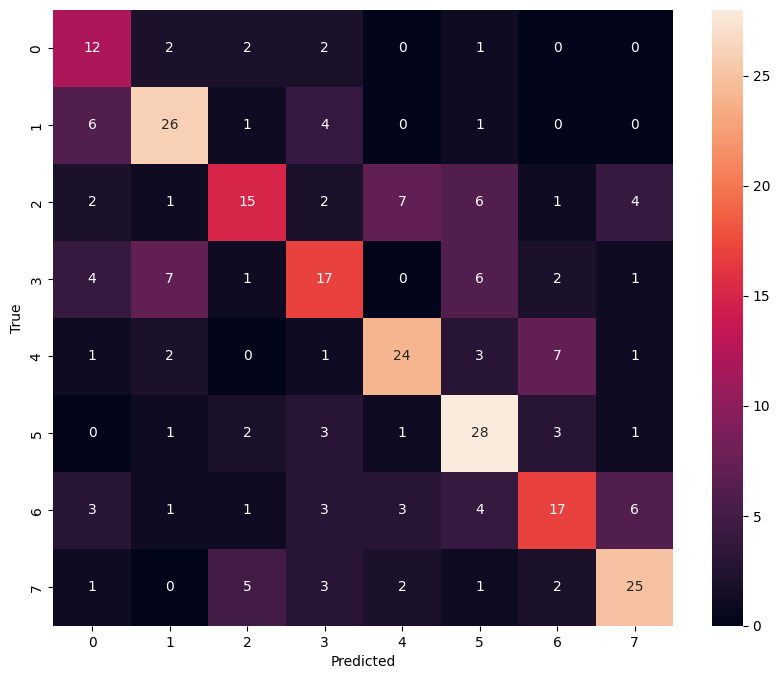

In [8]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {score[1]}")

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

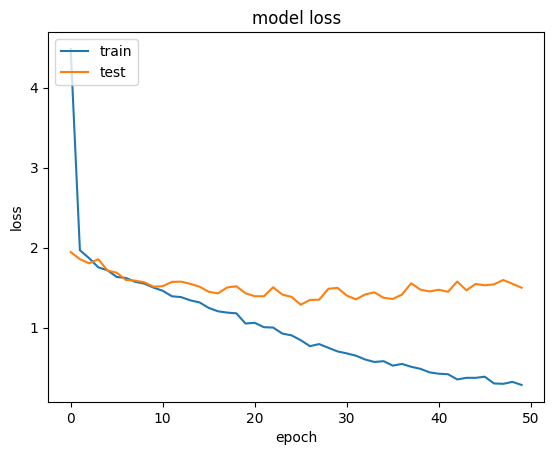

In [9]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

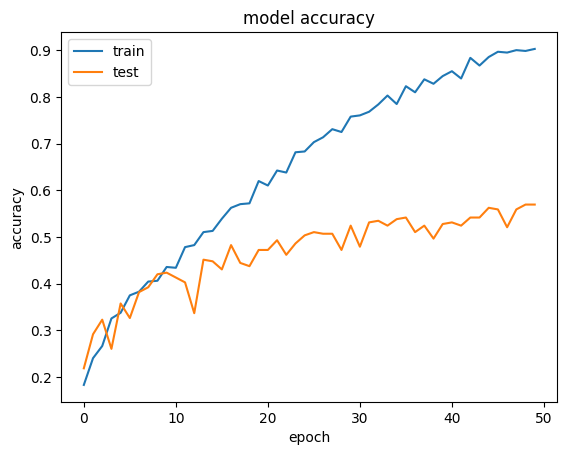

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [11]:
# Perform k-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store accuracy for each fold
cv_accuracies = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Reshape data to fit the model: (num_samples, timesteps, num_features)
    X_train_cv = np.expand_dims(X_train_cv, axis=-1)
    X_val_cv = np.expand_dims(X_val_cv, axis=-1)

    # Initialize a new model for each fold
    model_cv = Sequential()

    model_cv.add(
        Conv1D(
            64,
            5,
            padding="same",
            input_shape=(X_train_cv.shape[1], X_train_cv.shape[2]),
        )
    )
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(128, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(256, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))

    model_cv.add(Flatten())

    model_cv.add(Dense(8))
    model_cv.add(Activation("softmax"))

    # Define a new RMSprop optimizer with a lower learning rate for each fold
    opt_cv = RMSprop(learning_rate=0.001)

    model_cv.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt_cv, metrics=["accuracy"]
    )

    # Train the model
    model_cv.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, verbose=1)

    # Evaluate the model on validation data
    y_val_pred = model_cv.predict(X_val_cv)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    accuracy = accuracy_score(y_val_cv, y_val_pred_classes)
    cv_accuracies.append(accuracy)

# Print cross-validation accuracies and mean accuracy
print(f"Cross-validation accuracies: {cv_accuracies}")
print(f"Mean cross-validation accuracy: {np.mean(cv_accuracies)}")

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1257 - loss: 9.0440
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2498 - loss: 1.9572
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2780 - loss: 1.8723
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3457 - loss: 1.7858
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3076 - loss: 1.7309
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3594 - loss: 1.6686
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3613 - loss: 1.6447
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4042 - loss: 1.5852
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3903 - loss: 1.5768
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4090 - loss: 1.5167
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4688 - loss: 1.4493
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy:

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1491 - loss: 10.0218
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2253 - loss: 2.0207
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2681 - loss: 1.8797
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2861 - loss: 1.8825
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3610 - loss: 1.6811
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3561 - loss: 1.6607
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3800 - loss: 1.5954
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3815 - loss: 1.5753
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4275 - loss: 1.4904
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4487 - loss: 1.4564
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4481 - loss: 1.4391
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1516 - loss: 8.6982
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2514 - loss: 1.9814
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3033 - loss: 1.8293
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2720 - loss: 1.8193
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3312 - loss: 1.6821
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3919 - loss: 1.6351
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3957 - loss: 1.5945
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4411 - loss: 1.5005
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4370 - loss: 1.4920
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4730 - loss: 1.4585
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4677 - loss: 1.3993
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy:

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1389 - loss: 8.7967
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2315 - loss: 2.0072
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2215 - loss: 1.9553
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3052 - loss: 1.8230
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3304 - loss: 1.7859
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3384 - loss: 1.7088
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3695 - loss: 1.6467
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4132 - loss: 1.5628
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4047 - loss: 1.5616
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4133 - loss: 1.5303
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4226 - loss: 1.4680
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy:

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1629 - loss: 9.4484
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2521 - loss: 1.9325
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2523 - loss: 1.8451
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3232 - loss: 1.7369
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3625 - loss: 1.6543
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3659 - loss: 1.6424
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4109 - loss: 1.6112
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3700 - loss: 1.5828
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4573 - loss: 1.4847
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4865 - loss: 1.3814
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4913 - loss: 1.3916
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: